In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score



import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("Using CUDA (GPU)")
    device = torch.device("cuda")

elif torch.backends.mps.is_available():
    print("Using MPS (macOS)")
    device = torch.device("mps")
else:
    print("Using CPU (Default)")
    device = torch.device("cpu")

Using CUDA (GPU)


In [59]:
full_dataset = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

print("Duplicate rows in full_dataset:", full_dataset.duplicated().sum())
#check difference between the two datasets with duplicate rows and without

full_dataset = full_dataset.drop_duplicates()

print("Duplicate rows in full_dataset:", full_dataset.duplicated().sum())


print("full_dataset shape:", full_dataset.shape)
#check for null values

print("Null values in full_dataset:", full_dataset.isnull().sum().sum())
#no NANs cool
full_dataset = full_dataset.drop(columns=["Education", "Income","Fruits","Veggies","AnyHealthcare","NoDocbcCost" ])


full_dataset



Duplicate rows in full_dataset: 23899
Duplicate rows in full_dataset: 0
full_dataset shape: (229781, 22)
Null values in full_dataset: 0


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0


In [60]:
skew=full_dataset[["BMI","Age","PhysHlth","MentHlth"]].skew()
skew

BMI         2.063938
Age        -0.385147
PhysHlth    2.046245
MentHlth    2.546808
dtype: float64

In [61]:


from sklearn.preprocessing import StandardScaler


Scaler = StandardScaler()
full_dataset[["BMI","Age","PhysHlth","MentHlth"]]=Scaler.fit_transform(full_dataset[["BMI","Age","PhysHlth","MentHlth"]])

full_dataset

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,1.0,1.667220,1.0,0.0,0.0,0.0,0.0,5.0,1.879074,1.141300,1.0,0.0,0.295241
1,0.0,0.0,0.0,0.0,-0.543101,1.0,0.0,0.0,1.0,0.0,3.0,-0.454434,-0.516791,0.0,0.0,-0.351213
2,0.0,1.0,1.0,1.0,-0.101037,0.0,0.0,0.0,0.0,0.0,5.0,3.434746,2.799391,1.0,0.0,0.295241
3,0.0,1.0,0.0,1.0,-0.248391,0.0,0.0,0.0,1.0,0.0,2.0,-0.454434,-0.516791,0.0,0.0,0.941695
4,0.0,1.0,1.0,1.0,-0.690456,0.0,0.0,0.0,1.0,0.0,2.0,-0.065516,-0.516791,0.0,0.0,0.941695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,2.403993,0.0,0.0,0.0,0.0,0.0,3.0,-0.454434,0.035906,0.0,1.0,-0.997666
253676,2.0,1.0,1.0,1.0,-1.574584,0.0,0.0,0.0,0.0,0.0,4.0,-0.454434,-0.516791,1.0,0.0,0.941695
253677,0.0,0.0,0.0,1.0,-0.101037,0.0,0.0,0.0,1.0,0.0,1.0,-0.454434,-0.516791,0.0,0.0,-1.967347
253678,0.0,1.0,0.0,1.0,-0.837810,0.0,0.0,0.0,0.0,0.0,3.0,-0.454434,-0.516791,0.0,1.0,-0.351213


In [62]:
from sklearn.preprocessing import QuantileTransformer
QT=QuantileTransformer(n_quantiles=1000, random_state=0,output_distribution='normal')
full_dataset[["BMI","Age","PhysHlth","MentHlth"]]=QT.fit_transform(full_dataset[["BMI","Age","PhysHlth","MentHlth"]])
full_dataset

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,1.0,1.579968,1.0,0.0,0.0,0.0,0.0,5.0,1.431971,1.130517,1.0,0.0,0.160010
1,0.0,0.0,0.0,0.0,-0.512061,1.0,0.0,0.0,1.0,0.0,3.0,-5.199338,-5.199338,0.0,0.0,-0.436240
2,0.0,1.0,1.0,1.0,0.086674,0.0,0.0,0.0,0.0,0.0,5.0,5.199338,5.199338,1.0,0.0,0.160010
3,0.0,1.0,0.0,1.0,-0.109365,0.0,0.0,0.0,1.0,0.0,2.0,-5.199338,-5.199338,0.0,0.0,0.857097
4,0.0,1.0,1.0,1.0,-0.710366,0.0,0.0,0.0,1.0,0.0,2.0,0.748009,-5.199338,0.0,0.0,0.857097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,1.994971,0.0,0.0,0.0,0.0,0.0,3.0,-5.199338,0.744694,0.0,1.0,-0.914679
253676,2.0,1.0,1.0,1.0,-2.289988,0.0,0.0,0.0,0.0,0.0,4.0,-5.199338,-5.199338,1.0,0.0,0.857097
253677,0.0,0.0,0.0,1.0,0.086674,0.0,0.0,0.0,1.0,0.0,1.0,-5.199338,-5.199338,0.0,0.0,-1.733071
253678,0.0,1.0,0.0,1.0,-0.939747,0.0,0.0,0.0,0.0,0.0,3.0,-5.199338,-5.199338,0.0,1.0,-0.436240


In [63]:
skew=full_dataset[["BMI","Age","PhysHlth","MentHlth"]].skew()
skew


BMI         0.009105
Age         0.917934
PhysHlth    0.779101
MentHlth    0.990221
dtype: float64

In [64]:
print("duplicate rows in full_dataset:", full_dataset.duplicated().sum())

duplicate rows in full_dataset: 63678


In [65]:
full_dataset=full_dataset.drop_duplicates()

<Figure size 1200x1000 with 0 Axes>

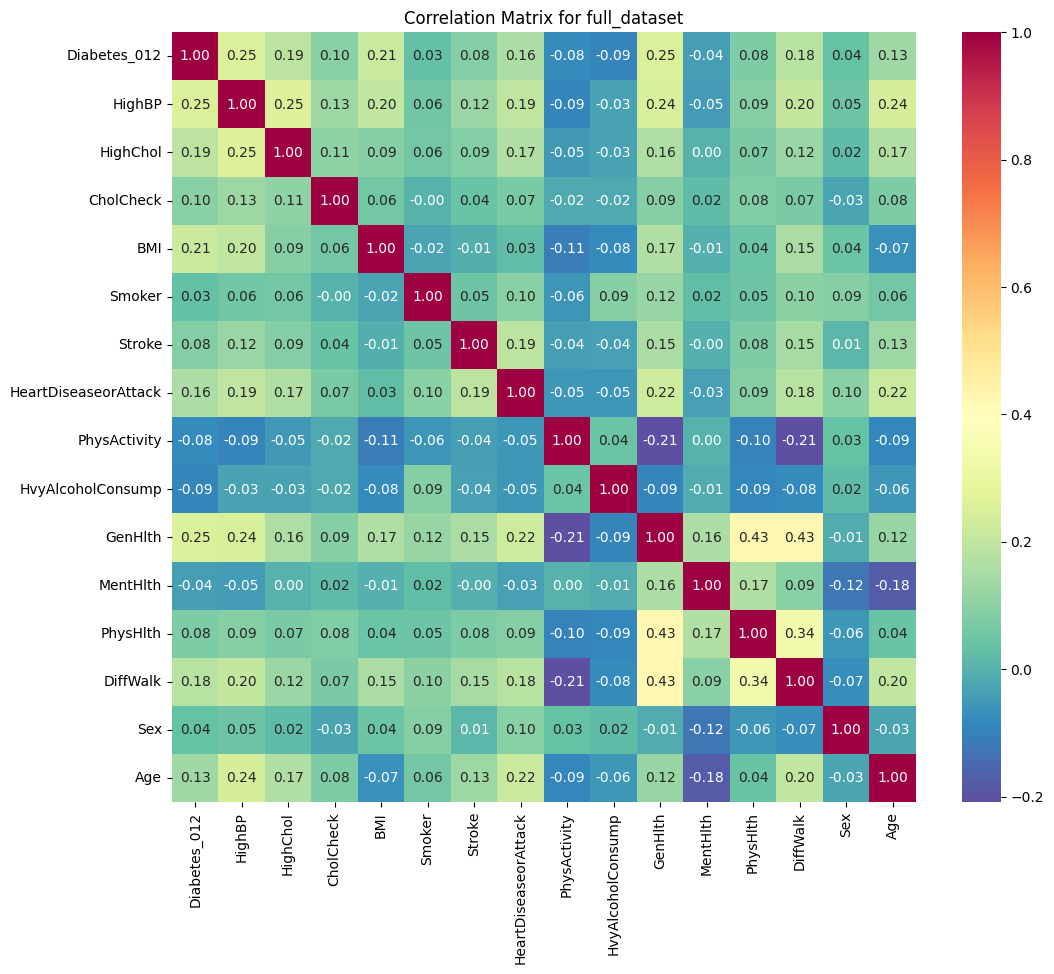

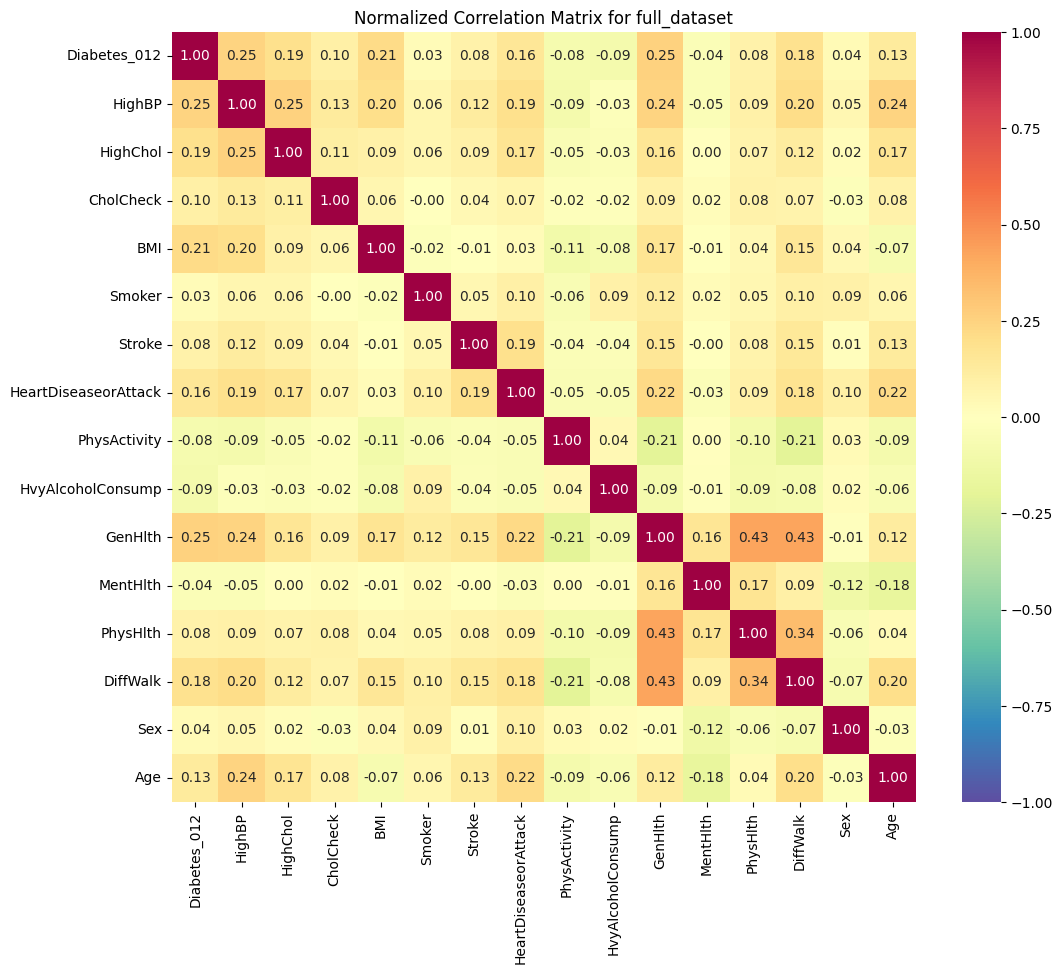

In [66]:
full_corr_matrix = full_dataset.corr()
plt.figure(figsize=(12, 10))


plt.figure(figsize=(12, 10))
sns.heatmap(full_corr_matrix, annot=True, fmt=".2f", cmap="Spectral_r")
plt.title("Correlation Matrix for full_dataset")
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(full_corr_matrix, annot=True, fmt=".2f", cmap="Spectral_r", vmin=-1, vmax=1)
plt.title("Normalized Correlation Matrix for full_dataset")
plt.show()

Diabetes_012
0.0    0.783490
2.0    0.189346
1.0    0.027164
Name: proportion, dtype: float64

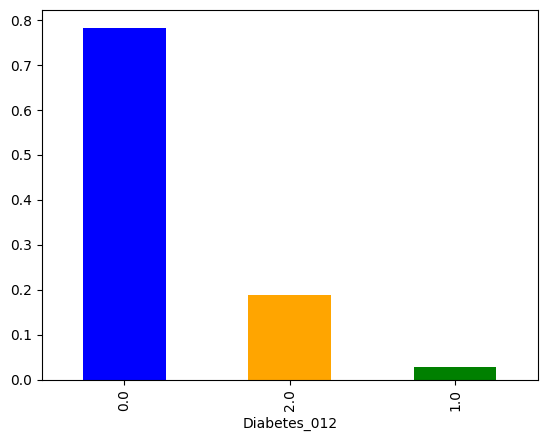

In [67]:
full_dataset["Diabetes_012"].value_counts(normalize=True).plot(kind="bar", color=["blue", "orange", "green"])
full_dataset["Diabetes_012"].value_counts(normalize=True)


In [68]:
crosstab_result = pd.crosstab(full_dataset['HighBP'],full_dataset['Diabetes_012'])
print(crosstab_result)
print((full_dataset.groupby('Diabetes_012')['HighBP'].value_counts())/full_dataset.groupby('Diabetes_012')['HighBP'].count()*100 ,"\n")



crosstab_result = pd.crosstab(full_dataset['HighChol'],full_dataset['Diabetes_012'])
print(crosstab_result,"\n")
print((full_dataset.groupby('Diabetes_012')['HighChol'].value_counts())/full_dataset.groupby('Diabetes_012')['HighChol'].count()*100 ,"\n")



crosstab_result = pd.crosstab(full_dataset['HeartDiseaseorAttack'],full_dataset['Diabetes_012'])
print(crosstab_result,"\n")
print((full_dataset.groupby('Diabetes_012')['HeartDiseaseorAttack'].value_counts())/full_dataset.groupby('Diabetes_012')['HeartDiseaseorAttack'].count()*100 ,"\n")


crosstab_result = pd.crosstab(full_dataset['PhysActivity'],full_dataset['Diabetes_012'])
print(crosstab_result),"\n"
print((full_dataset.groupby('Diabetes_012')['PhysActivity'].value_counts())/full_dataset.groupby('Diabetes_012')['PhysActivity'].count()*100 ,"\n")


Diabetes_012    0.0   1.0    2.0
HighBP                          
0.0           74308  1686   8040
1.0           55832  2826  23411
Diabetes_012  HighBP
0.0           0.0       57.098509
              1.0       42.901491
1.0           1.0       62.632979
              0.0       37.367021
2.0           1.0       74.436425
              0.0       25.563575
dtype: float64 

Diabetes_012    0.0   1.0    2.0
HighChol                        
0.0           75023  1725  10574
1.0           55117  2787  20877 

Diabetes_012  HighChol
0.0           0.0         57.647918
              1.0         42.352082
1.0           1.0         61.768617
              0.0         38.231383
2.0           1.0         66.379447
              0.0         33.620553
dtype: float64 

Diabetes_012             0.0   1.0    2.0
HeartDiseaseorAttack                     
0.0                   116484  3853  23913
1.0                    13656   659   7538 

Diabetes_012  HeartDiseaseorAttack
0.0           0.0              

In [69]:
from sklearn.metrics import classification_report
log_reg = LogisticRegression(max_iter=10000, random_state=42)
X = full_dataset.drop(columns=["Diabetes_012"])
y = full_dataset["Diabetes_012"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Logistic Regression Accuracy: 0.7907928799341776
Confusion Matrix:
 [[37646     0  1396]
 [ 1236     0   118]
 [ 7675     0  1760]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.96      0.88     39042
         1.0       0.00      0.00      0.00      1354
         2.0       0.54      0.19      0.28      9435

    accuracy                           0.79     49831
   macro avg       0.45      0.38      0.39     49831
weighted avg       0.74      0.79      0.74     49831



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [70]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42,max_depth=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Random Forest Accuracy: 0.7917160000802713
Confusion Matrix:
 [[37847     0  1195]
 [ 1244     0   110]
 [ 7830     0  1605]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.97      0.88     39042
         1.0       0.00      0.00      0.00      1354
         2.0       0.55      0.17      0.26      9435

    accuracy                           0.79     49831
   macro avg       0.45      0.38      0.38     49831
weighted avg       0.74      0.79      0.74     49831



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [71]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, random_state=42, max_depth=15)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

XGBoost Accuracy: 0.7353655355100239
Confusion Matrix:
 [[34284   290  4468]
 [ 1064     4   286]
 [ 6991    88  2356]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.88      0.84     39042
         1.0       0.01      0.00      0.00      1354
         2.0       0.33      0.25      0.28      9435

    accuracy                           0.74     49831
   macro avg       0.38      0.38      0.38     49831
weighted avg       0.70      0.74      0.71     49831



In [40]:
from imblearn.over_sampling import SMOTE

# Separate features and target variable
X = full_dataset.drop(columns=['Diabetes_012'])
y = full_dataset['Diabetes_012']

xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)


# keep for later
xtest
print(ytest.value_counts())


# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(xtrain, ytrain)

# Combine resampled features and target into a new DataFrame
resampled_dataset = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Diabetes_012'])], axis=1)

print("Original dataset shape:", full_dataset['Diabetes_012'].value_counts())
print("Resampled dataset shape:", y_resampled.value_counts())



Diabetes_012
0.0    39042
2.0     9435
1.0     1354
Name: count, dtype: int64
Original dataset shape: Diabetes_012
0.0    130140
2.0     31451
1.0      4512
Name: count, dtype: int64
Resampled dataset shape: Diabetes_012
0.0    91098
2.0    91098
1.0    91098
Name: count, dtype: int64


In [41]:
from sklearn.metrics import classification_report
log_reg = LogisticRegression(max_iter=10000, random_state=42)

X_train = X_resampled
y_train = y_resampled

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

print(ytrain.info())

Logistic Regression Accuracy: 0.5771307017719893
Confusion Matrix:
 [[23280  8286  7476]
 [  416   457   481]
 [ 1826  2587  5022]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.60      0.72     39042
         1.0       0.04      0.34      0.07      1354
         2.0       0.39      0.53      0.45      9435

    accuracy                           0.58     49831
   macro avg       0.45      0.49      0.41     49831
weighted avg       0.79      0.58      0.65     49831

<class 'pandas.core.series.Series'>
Index: 116272 entries, 41151 to 242088
Series name: Diabetes_012
Non-Null Count   Dtype  
--------------   -----  
116272 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB
None


In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42,max_depth=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Random Forest Accuracy: 0.6979791695932251
Confusion Matrix:
 [[29401  2274  7367]
 [  621   237   496]
 [ 3236  1056  5143]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.75      0.81     39042
         1.0       0.07      0.18      0.10      1354
         2.0       0.40      0.55      0.46      9435

    accuracy                           0.70     49831
   macro avg       0.45      0.49      0.46     49831
weighted avg       0.77      0.70      0.73     49831



In [43]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, random_state=42, max_depth=15)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

XGBoost Accuracy: 0.7392386265577653
Confusion Matrix:
 [[34350   403  4289]
 [ 1053     8   293]
 [ 6761   195  2479]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.88      0.85     39042
         1.0       0.01      0.01      0.01      1354
         2.0       0.35      0.26      0.30      9435

    accuracy                           0.74     49831
   macro avg       0.39      0.38      0.38     49831
weighted avg       0.71      0.74      0.72     49831



In [48]:
from imblearn.over_sampling import ADASYN
Adasyn = ADASYN(random_state=42)

X = full_dataset.drop(columns=['Diabetes_012'])
y = full_dataset['Diabetes_012']

xtrain,X_test,ytrain,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)


X_resampled, y_resampled = Adasyn.fit_resample(xtrain, ytrain)
# Combine resampled features and target into a new DataFrame
resampled_dataset = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Diabetes_012'])], axis=1)
print("Original dataset shape:", full_dataset['Diabetes_012'].value_counts())
print("Resampled dataset shape:", y_resampled.value_counts())

Original dataset shape: Diabetes_012
0.0    130140
2.0     31451
1.0      4512
Name: count, dtype: int64
Resampled dataset shape: Diabetes_012
2.0    94534
1.0    91364
0.0    91098
Name: count, dtype: int64


In [49]:
from sklearn.metrics import classification_report
log_reg = LogisticRegression(max_iter=10000, random_state=42)

X_train = resampled_dataset.drop(columns=["Diabetes_012"])
y_train = resampled_dataset["Diabetes_012"]

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Logistic Regression Accuracy: 0.575224257992013
Confusion Matrix:
 [[22913  7534  8595]
 [  403   414   537]
 [ 1742  2356  5337]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.59      0.71     39042
         1.0       0.04      0.31      0.07      1354
         2.0       0.37      0.57      0.45      9435

    accuracy                           0.58     49831
   macro avg       0.44      0.49      0.41     49831
weighted avg       0.79      0.58      0.65     49831



In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42,max_depth=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Random Forest Accuracy: 0.6937247897894885
Confusion Matrix:
 [[28800  1617  8625]
 [  577   188   589]
 [ 3057   797  5581]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.74      0.81     39042
         1.0       0.07      0.14      0.10      1354
         2.0       0.38      0.59      0.46      9435

    accuracy                           0.69     49831
   macro avg       0.45      0.49      0.45     49831
weighted avg       0.77      0.69      0.72     49831



In [51]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, random_state=42, max_depth=15)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

XGBoost Accuracy: 0.7380345568019907
Confusion Matrix:
 [[34268   430  4344]
 [ 1035    11   308]
 [ 6747   190  2498]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.88      0.85     39042
         1.0       0.02      0.01      0.01      1354
         2.0       0.35      0.26      0.30      9435

    accuracy                           0.74     49831
   macro avg       0.39      0.38      0.39     49831
weighted avg       0.71      0.74      0.72     49831



In [52]:
import cudf
import cupy as cp
from cuml.svm import LinearSVC,SVC

from cuml.model_selection import train_test_split

# Convert the DataFrame to a cuDF DataFrame
gdf = cudf.DataFrame.from_records(resampled_dataset.values, columns=resampled_dataset.columns)
# Separate features and target variable
X_cuml = gdf.drop(columns=["Diabetes_012"])
y_cuml = gdf["Diabetes_012"]


X_train_cuml = cudf.DataFrame.from_pandas(X_resampled)
X_test_cuml = cudf.DataFrame.from_pandas(X_test)
y_train_cuml = cudf.Series.from_pandas(y_resampled)
y_test_cuml = cudf.Series.from_pandas(y_test)



svc = SVC(kernel='rbf',C=10.0,gamma=1)
svc.fit(X_train_cuml, y_train_cuml)
y_pred_cuml = svc.predict(X_test_cuml)


accuracy_cuml = accuracy_score(y_test_cuml.to_pandas(), y_pred_cuml.to_pandas())
conf_mat_cuml = confusion_matrix(y_test_cuml.to_pandas(), y_pred_cuml.to_pandas())
class_report_cuml = classification_report(y_test_cuml.to_pandas(), y_pred_cuml.to_pandas())
print("cuML SVC Accuracy:", accuracy_cuml)
print("Confusion Matrix:\n", conf_mat_cuml)
print("Classification Report:\n", class_report_cuml)



y_pred_cuml = svc.predict(cudf.DataFrame.from_records(X.values, columns=X.columns))

accuracy_cuml = accuracy_score(y, y_pred_cuml.to_pandas())
conf_mat_cuml = confusion_matrix(y, y_pred_cuml.to_pandas())
class_report_cuml = classification_report(y, y_pred_cuml.to_pandas())
print("cuML SVC Accuracy:", accuracy_cuml)
print("Confusion Matrix:\n", conf_mat_cuml)
print("Classification Report:\n", class_report_cuml)

cuML SVC Accuracy: 0.654291505287873
Confusion Matrix:
 [[28583  2217  8242]
 [  682   148   524]
 [ 4648   914  3873]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.73      0.78     39042
         1.0       0.05      0.11      0.06      1354
         2.0       0.31      0.41      0.35      9435

    accuracy                           0.65     49831
   macro avg       0.40      0.42      0.40     49831
weighted avg       0.72      0.65      0.68     49831

cuML SVC Accuracy: 0.7874692209051011
Confusion Matrix:
 [[103866   6093  20181]
 [   693   3232    587]
 [  5477   2271  23703]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.80      0.86    130140
         1.0       0.28      0.72      0.40      4512
         2.0       0.53      0.75      0.62     31451

    accuracy                           0.79    166103
   macro avg       0.59      0.76      0.63    16

Accuracy (Random Split): 0.7896
Precision: 0.7477
Recall: 0.7896
F1 Score: 0.7076
classification report
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     26076
         1.0       0.00      0.00      0.00       889
         2.0       0.67      0.04      0.08      6255

    accuracy                           0.79     33220
   macro avg       0.49      0.35      0.32     33220
weighted avg       0.75      0.79      0.71     33220



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

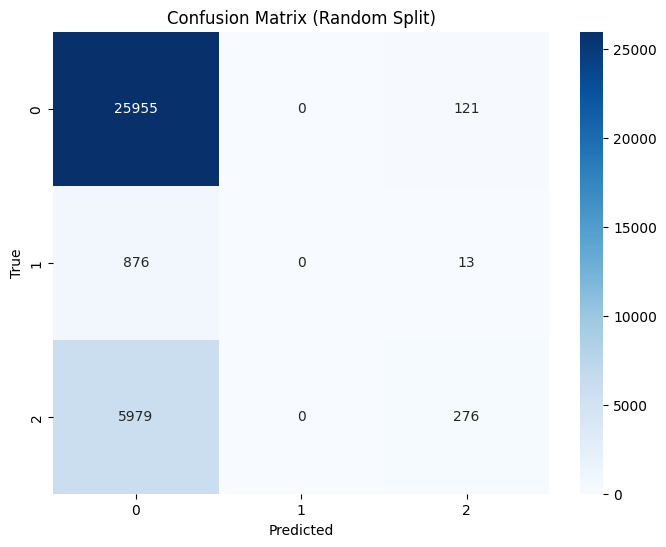

In [53]:
import cudf
import cupy as cp
from cuml.svm import SVC
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.model_selection import train_test_split as cuml_train_test_split
#convert pandas dataframe to cudf dataframe
cudf_full = cudf.DataFrame.from_pandas(full_dataset)
# Separate features and target variable
X_cudf = cudf_full.drop(columns=['Diabetes_012'])
y_cudf = cudf_full['Diabetes_012']

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovo')
# Random split of the resampled dataset
X_train_random_cudf, X_test_random_cudf, y_train_random_cudf, y_test_random_cudf = cuml_train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf, y_train_random_cudf)
# Make predictions on the test set
y_pred_random_cudf = svm_model.predict(X_test_random_cudf)
# Calculate accuracy
accuracy_random_cudf = cuml_accuracy_score(y_test_random_cudf, y_pred_random_cudf)
print(f"Accuracy (Random Split): {accuracy_random_cudf:.4f}")
#precision
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision in pandas
precision = precision_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
recall = recall_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
f1 = f1_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns
import matplotlib.pyplot as plt
print("classification report")
print(classification_report(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy()))
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


Accuracy (Random Split): 0.5129
Precision: 0.5356
Recall: 0.5129
F1 Score: 0.4426


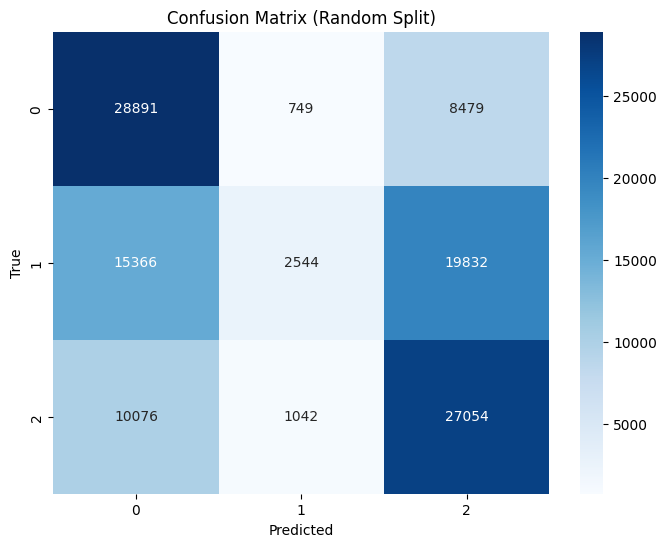

In [10]:
import cudf
import cupy as cp
from cuml.svm import SVC
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.model_selection import train_test_split as cuml_train_test_split
#convert pandas dataframe to cudf dataframe
cudf_smote = cudf.DataFrame.from_pandas(resampled_dataset)
# Separate features and target variable
X_cudf = cudf_smote.drop(columns=['Diabetes_012'])
y_cudf = cudf_smote['Diabetes_012']

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr')
# Random split of the resampled dataset
X_train_random_cudf, X_test_random_cudf, y_train_random_cudf, y_test_random_cudf = cuml_train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf, y_train_random_cudf)
# Make predictions on the test set
y_pred_random_cudf = svm_model.predict(X_test_random_cudf)
# Calculate accuracy
accuracy_random_cudf = cuml_accuracy_score(y_test_random_cudf, y_pred_random_cudf)
print(f"Accuracy (Random Split): {accuracy_random_cudf:.4f}")
#precision
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision in pandas
precision = precision_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
recall = recall_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
f1 = f1_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


Precision: 0.5375
Recall: 0.5383
F1 Score: 0.5348


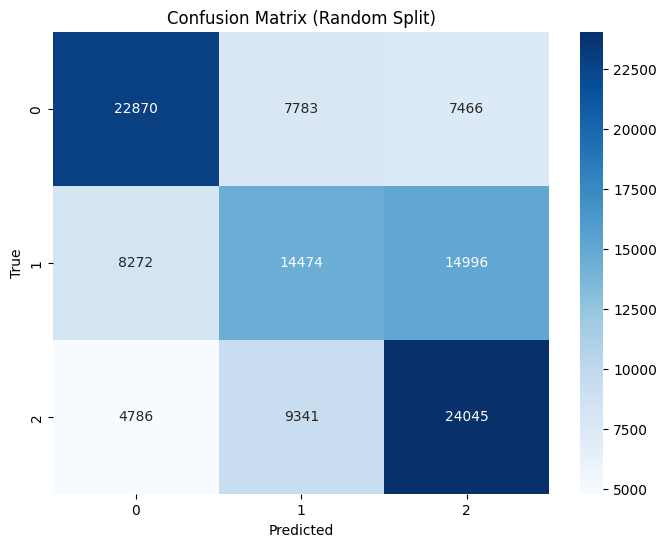

In [9]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


In [15]:
#SVC in rus tomex and near miss

#convert pandas dataframe to cudf dataframe
X_cudf_rus = cudf.DataFrame.from_pandas(X_rus)
y_cudf_rus = cudf.Series(y_rus)

X_cudf_tomek = cudf.DataFrame.from_pandas(X_tomek)
y_cudf_tomek = cudf.Series(y_tomek)

X_cudf_nm = cudf.DataFrame.from_pandas(X_nm)
y_cudf_nm = cudf.Series(y_nm)

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovo')
# Random split of the resampled dataset
X_train_random_cudf_rus, X_test_random_cudf_rus, y_train_random_cudf_rus, y_test_random_cudf_rus = cuml_train_test_split(X_cudf_rus, y_cudf_rus, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf_rus, y_train_random_cudf_rus)
y_pred_random_cudf_rus = svm_model.predict(X_test_random_cudf_rus)

# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_random_cudf_rus.to_numpy(), y_pred_random_cudf_rus.to_numpy()))
print("classification report random undersampling")
print(classification_report(y_test_random_cudf_rus.to_numpy(), y_pred_random_cudf_rus.to_numpy()))

X_train_tomek, X_test_tomek, y_train_tomek, y_test_tomek = cuml_train_test_split(X_cudf_tomek, y_cudf_tomek, test_size=0.2, random_state=42)
svm_model.fit(X_train_tomek, y_train_tomek)
y_pred_random_cudf_tomek = svm_model.predict(X_test_tomek)

# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_tomek.to_numpy(), y_pred_random_cudf_tomek.to_numpy()))

print("classification report Tomek links")
print(classification_report(y_test_tomek.to_numpy(), y_pred_random_cudf_tomek.to_numpy()))

X_train_nm, X_test_nm, y_train_nm, y_test_nm = cuml_train_test_split(X_cudf_nm, y_cudf_nm, test_size=0.2, random_state=42)
svm_model.fit(X_train_nm, y_train_nm)
y_pred_random_cudf_nm = svm_model.predict(X_test_nm)
# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_nm.to_numpy(), y_pred_random_cudf_nm.to_numpy()))
print("classification report near misss")
print(classification_report(y_test_nm.to_numpy(), y_pred_random_cudf_nm.to_numpy()))

confusion matrix
[[515 247 160]
 [257 290 375]
 [137 269 527]]
classification report random undersampling
              precision    recall  f1-score   support

         0.0       0.57      0.56      0.56       922
         1.0       0.36      0.31      0.34       922
         2.0       0.50      0.56      0.53       933

    accuracy                           0.48      2777
   macro avg       0.47      0.48      0.48      2777
weighted avg       0.47      0.48      0.48      2777

confusion matrix
[[36104     0    70]
 [  925     0     9]
 [ 5295     0   144]]
classification report Tomek links
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92     36174
         1.0       0.00      0.00      0.00       934
         2.0       0.65      0.03      0.05      5439

    accuracy                           0.85     42547
   macro avg       0.50      0.34      0.32     42547
weighted avg       0.81      0.85      0.79     42547



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

confusion matrix
[[695   0 227]
 [113 604 205]
 [338  17 578]]
classification report near misss
              precision    recall  f1-score   support

         0.0       0.61      0.75      0.67       922
         1.0       0.97      0.66      0.78       922
         2.0       0.57      0.62      0.59       933

    accuracy                           0.68      2777
   macro avg       0.72      0.68      0.68      2777
weighted avg       0.72      0.68      0.68      2777



In [17]:
class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size_1,hidden_seize_2, output_size):
        super(neural_net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_seize_2)
        self.fc3 = nn.Linear(hidden_seize_2, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    




In [18]:
model=neural_net(input_size=20, hidden_size_1=64, hidden_seize_2=32, output_size=3).to(device)
print(model)

neural_net(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [24]:
from sklearn.model_selection import KFold
import torch

# Prepare data for PyTorch
X = torch.tensor(X_resampled.values, dtype=torch.float32)
y = torch.tensor(y_resampled.values, dtype=torch.int64)

# K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
num_epochs = 20
input_size = X.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 3
batch_size = 256

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} accuracy: {acc:.4f}")

print(f"Mean cross-validated accuracy over 5 folds: {np.mean(fold_accuracies):.4f}")


  

Fold 1 accuracy: 0.7056
Fold 2 accuracy: 0.7054
Fold 3 accuracy: 0.7177
Fold 4 accuracy: 0.6952
Fold 5 accuracy: 0.7004
Fold 6 accuracy: 0.6948
Fold 7 accuracy: 0.7007
Fold 8 accuracy: 0.7004
Fold 9 accuracy: 0.6886
Fold 10 accuracy: 0.6985
Mean cross-validated accuracy over 5 folds: 0.7007


In [25]:
from sklearn.metrics import classification_report

def run_kfold_nn(X_df, y_series, input_size, hidden_size_1, hidden_size_2, output_size, num_epochs=20, batch_size=256):
    X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_series.values, dtype=torch.int64)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
        model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        for epoch in range(num_epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                outputs = model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        all_preds = []
        all_true = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_true.extend(yb.cpu().numpy())
        acc = np.mean(np.array(all_preds) == np.array(all_true))
        fold_accuracies.append(acc)
        print(f"Fold {fold+1} accuracy: {acc:.4f}")
        print(f"Classification report for fold {fold+1}:\n{classification_report(all_true, all_preds)}")

    print(f"Mean cross-validated accuracy over 10 folds: {np.mean(fold_accuracies):.4f}")
    return fold_accuracies

# Prepare datasets
datasets = [
    ("RandomUnderSampler", X_rus, y_rus),
    ("TomekLinks", X_tomek, y_tomek),
    ("NearMiss", X_nm, y_nm)
]

for name, X_df, y_series in datasets:
    print(f"\n{name} dataset:")
    run_kfold_nn(
        X_df, y_series,
        input_size=X_df.shape[1],
        hidden_size_1=hidden_size_1,
        hidden_size_2=hidden_size_2,
        output_size=output_size,
        num_epochs=num_epochs,
        batch_size=256
    )



RandomUnderSampler dataset:
Fold 1 accuracy: 0.5133
Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       464
           1       0.44      0.20      0.28       481
           2       0.47      0.73      0.57       444

    accuracy                           0.51      1389
   macro avg       0.51      0.52      0.49      1389
weighted avg       0.51      0.51      0.49      1389

Fold 2 accuracy: 0.4888
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.55      0.58      0.57       470
           1       0.37      0.28      0.32       452
           2       0.50      0.60      0.55       467

    accuracy                           0.49      1389
   macro avg       0.48      0.49      0.48      1389
weighted avg       0.48      0.49      0.48      1389

Fold 3 accuracy: 0.4917
Classification report for fold 3:
              precision    recall  

/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 accuracy: 0.8539
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18165
           1       0.00      0.00      0.00       459
           2       0.00      0.00      0.00      2650

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 accuracy: 0.8490
Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18062
           1       0.00      0.00      0.00       506
           2       0.00      0.00      0.00      2706

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.72      0.85      0.78     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 accuracy: 0.8529
Classification report for fold 4:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18144
           1       0.00      0.00      0.00       453
           2       0.00      0.00      0.00      2677

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 accuracy: 0.8520
Classification report for fold 5:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18125
           1       0.00      0.00      0.00       452
           2       0.00      0.00      0.00      2697

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.78     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 6 accuracy: 0.8535
Classification report for fold 6:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18157
           1       0.00      0.00      0.00       458
           2       0.00      0.00      0.00      2659

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 7 accuracy: 0.8539
Classification report for fold 7:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18166
           1       0.00      0.00      0.00       458
           2       0.00      0.00      0.00      2649

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.73      0.85      0.79     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 8 accuracy: 0.8468
Classification report for fold 8:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18013
           1       0.00      0.00      0.00       470
           2       0.00      0.00      0.00      2790

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.72      0.85      0.78     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 9 accuracy: 0.8523
Classification report for fold 9:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18130
           1       0.00      0.00      0.00       480
           2       0.00      0.00      0.00      2663

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.73      0.85      0.78     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 10 accuracy: 0.8494
Classification report for fold 10:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18069
           1       0.00      0.00      0.00       452
           2       0.00      0.00      0.00      2752

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.72      0.85      0.78     21273

Mean cross-validated accuracy over 10 folds: 0.8516

NearMiss dataset:


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 1 accuracy: 0.7019
Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       464
           1       0.92      0.73      0.81       481
           2       0.56      0.72      0.63       444

    accuracy                           0.70      1389
   macro avg       0.72      0.70      0.71      1389
weighted avg       0.73      0.70      0.71      1389

Fold 2 accuracy: 0.6940
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.65      0.70      0.68       470
           1       0.96      0.70      0.81       452
           2       0.57      0.68      0.62       467

    accuracy                           0.69      1389
   macro avg       0.73      0.69      0.70      1389
weighted avg       0.73      0.69      0.70      1389

Fold 3 accuracy: 0.6926
Classification report for fold 3:
              precision    recall  f1-score   support

         